In [7]:
import pandas as pd
import requests
from erddapy import ERDDAP


def test_erddap_connection(url=''):
    e = ERDDAP(server=url)
    url = e.get_search_url(search_for="dy", response="csv")
    r = requests.head(url)
    assert r.raise_for_status() is None


def erddapCTDretrieve(url=None, cruiseid=None, concastno='001', qclevel='final'):
    """Retrieve a single cast from a FOCI cruise hosted via erddap

    Args:
        url (str, optional): url to foci hosted erddap. Defaults to ''.
        cruiseid (str, optional): standard foci cruise id without hyphens. eg dy2103 Defaults to ''.
        concastno (str, optional): three digit foci consecutive cast number. Defaults to '001'.
        qclevel (str, optional): preliminary or final. Defaults to 'final'.
    """

    e = ERDDAP(
      server=url,
      protocol="tabledap",
    )

    e.dataset_id = f'CTD_{cruiseid}_{qclevel}'

    df = e.to_pandas(parse_dates=True)

    try:
        df = df[df.profile_id.str.contains(concastno)]
    except:
        df = df.dropna()[df.dropna().profile_id.str.contains(concastno)]

    return df


def erddapMooredInstretrieve(url=None, mooringid=None, qclevel='final', instrid=None):
    """Retrieve a single instrument from a FOCI mooring hosted via erddap

    Args:
        url (str, optional): url to foci hosted erddap. Defaults to ''.
        cruiseid (str, optional): standard foci mooring id without hyphens. eg 19bs2c Defaults to ''.
        instrid (str, optional): full instrument reference - 19bs2c_s37_0064m - usually the archived filenmame.
        qclevel (str, optional): preliminary or final. Defaults to 'final'.
    """

    e = ERDDAP(
      server=url,
      protocol="tabledap",
    )

    e.dataset_id = f'datasets_Mooring_{mooringid}_{qclevel}'

    df = e.to_pandas(parse_dates=True)

    # try:
    #     df = df[df['timeseries_id'] == instrid].dropna(how='all', axis=1)
    # except:
    #     df = df

    return df

In [8]:
timeseries ={'url':"http://ecofoci-field.pmel.noaa.gov:8080/erddap",
             'mooringid':'14ckp7a',
             'qclevel':'final',
             'instrid':'14ckp7a_ecf_0039m'
            }
df = erddapMooredInstretrieve(**timeseries)
df = df.set_index(pd.DatetimeIndex(df['time (UTC)']))

<Axes: xlabel='time (UTC)'>

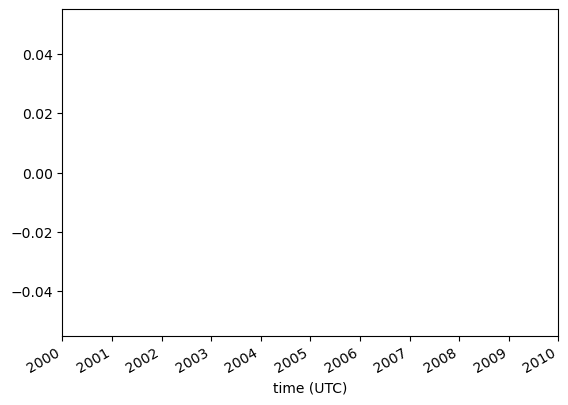

In [12]:
df['chlorophyll_fluorescence (micrograms (ug) / l)'].plot()

In [14]:
df.dropna(how='all', axis=1)

,time (UTC),depth (m),latitude (degrees_north),longitude (degrees_east),temperature (degree_C),salinity,par (umol m-2 s-1),timeseries_id,Instrument_Identifier,Water_Depth (dbar)
time (UTC),,,,,,,,,,
2014-10-03 01:00:00+00:00,2014-10-03T01:00:00Z,39.0,72.424580,198.379333,-0.6771,32.1396,1.000000e+39,14ckp7a_sc_0039m,SBE39,42.0
2014-10-03 02:00:00+00:00,2014-10-03T02:00:00Z,39.0,72.424580,198.379333,-0.6531,32.1355,1.000000e+39,14ckp7a_sc_0039m,SBE39,42.0
2014-10-03 03:00:00+00:00,2014-10-03T03:00:00Z,39.0,72.424580,198.379333,-0.6466,32.1303,1.000000e+39,14ckp7a_sc_0039m,SBE39,42.0
2014-10-03 04:00:00+00:00,2014-10-03T04:00:00Z,39.0,72.424580,198.379333,-0.6437,32.1251,1.000000e+39,14ckp7a_sc_0039m,SBE39,42.0
2014-10-03 05:00:00+00:00,2014-10-03T05:00:00Z,39.0,72.424580,198.379333,-0.6451,32.1241,1.000000e+39,14ckp7a_sc_0039m,SBE39,42.0
...,...,...,...,...,...,...,...,...,...,...
2015-09-16 23:00:00+00:00,2015-09-16T23:00:00Z,36.0,71.776665,198.121002,-1.4800,NaN,NaN,14ckp7a_ecf_0039m,wcp,42.0
2015-09-17 00:00:00+00:00,2015-09-17T00:00:00Z,36.0,71.776665,198.121002,-1.4700,NaN,NaN,14ckp7a_ecf_0039m,wcp,42.0
2015-09-17 01:00:00+00:00,2015-09-17T01:00:00Z,36.0,71.776665,198.121002,-1.4700,NaN,NaN,14ckp7a_ecf_0039m,wcp,42.0
